#Import Libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.metrics import confusion_matrix, adjusted_rand_score
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.neighbors import NearestNeighbors

#Load dataset

In [ ]:
# Load dataset
from sklearn.datasets import load_iris
iris = load_iris()
X = pd.DataFrame(iris.data, columns=iris.feature_names)
y = iris.target
target_names = iris.target_names

print("Shape of dataset:", X.shape)
print('\n')
X.head()

Shape of dataset: (150, 4)




,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2


#Exploratory Data Analysis (EDA)

In [ ]:
# Basic statistics
print("\nDataset Summary:")
display(X.describe().T)

print('\n')

# Check missing values
print("\nMissing values per column:")
print(X.isnull().sum())


Dataset Summary:


,count,mean,std,min,25%,50%,75%,max
sepal length (cm),150.0,5.843333,0.828066,4.3,5.1,5.80,6.4,7.9
sepal width (cm),150.0,3.057333,0.435866,2.0,2.8,3.00,3.3,4.4
petal length (cm),150.0,3.758000,1.765298,1.0,1.6,4.35,5.1,6.9
petal width (cm),150.0,1.199333,0.762238,0.1,0.3,1.30,1.8,2.5





Missing values per column:
sepal length (cm)    0
sepal width (cm)     0
petal length (cm)    0
petal width (cm)     0
dtype: int64


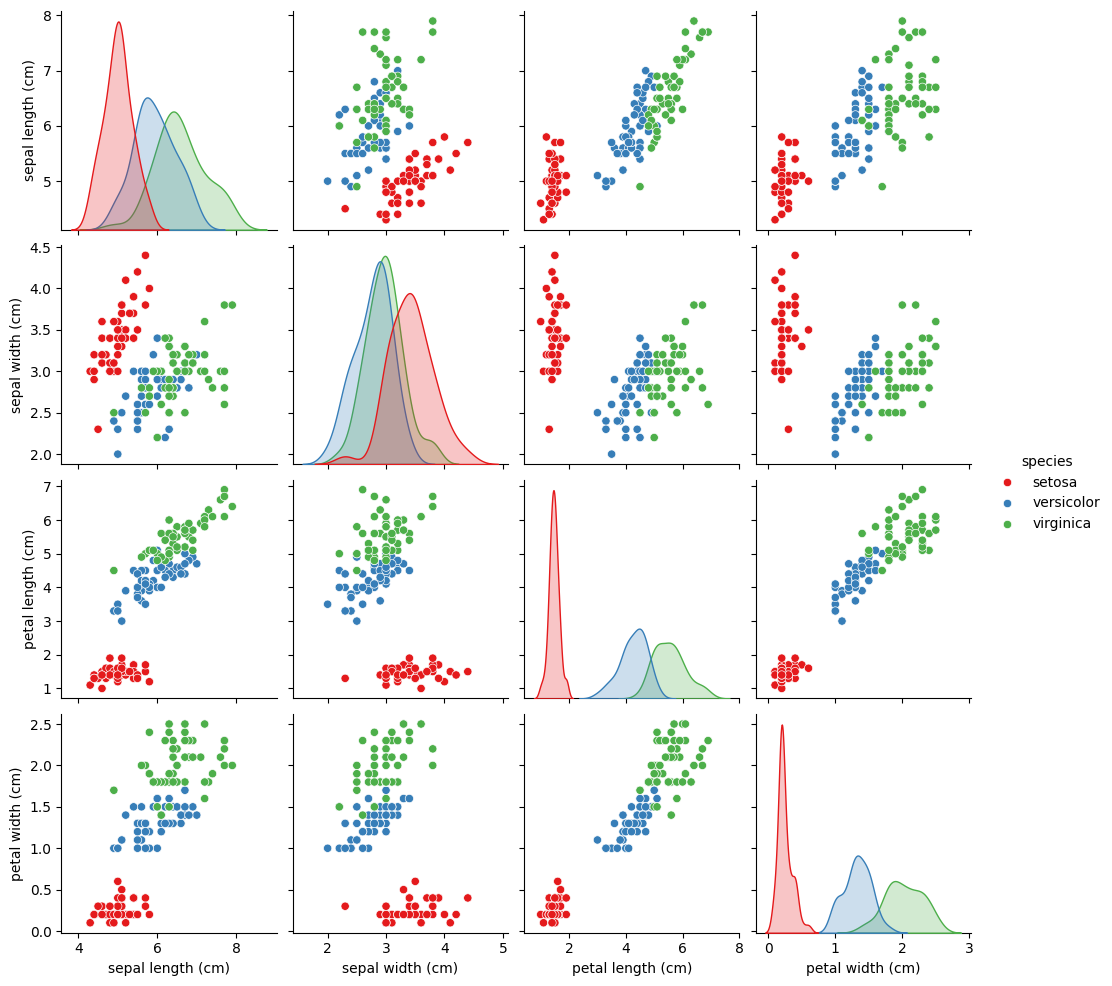

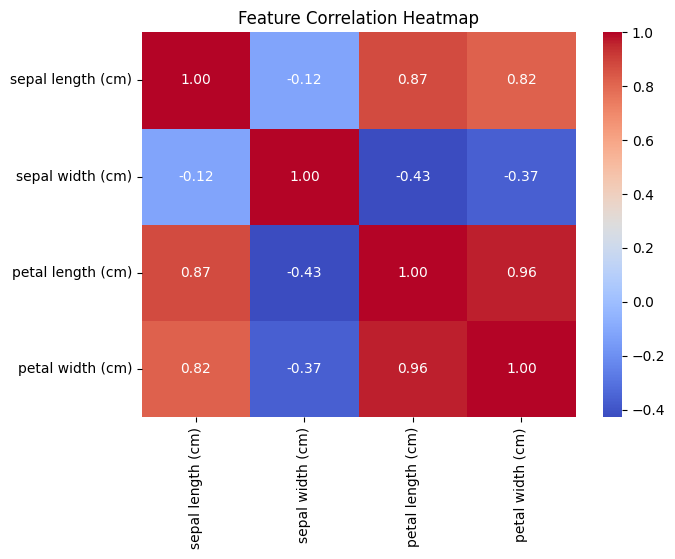

In [ ]:
# Pairplot
sns.pairplot(pd.DataFrame(iris.data, columns=iris.feature_names)
             .assign(species=[target_names[i] for i in y]),
             hue="species", palette="Set1")
plt.show()

print('\n')

# Correlation heatmap
plt.figure(figsize=(7,5))
sns.heatmap(X.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Feature Correlation Heatmap")
plt.show()

#Scale Features

In [ ]:
# Scale Features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

#PCA for Visualization

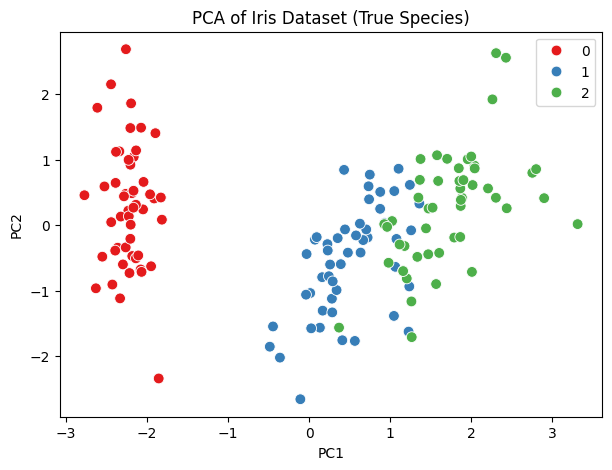

In [ ]:
# PCA for Visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(7,5))
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=y, palette="Set1", s=60)
plt.title("PCA of Iris Dataset (True Species)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

#Clustering Algorithms

#A. K-Means Clustering

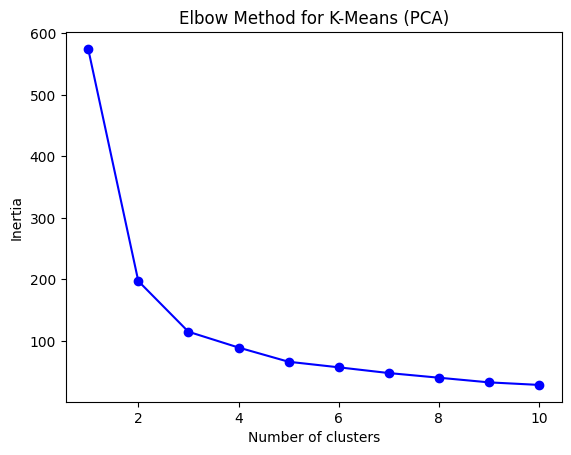

In [ ]:
# Elbow method
inertia = []
K = range(1, 11)
for k in K:
    km = KMeans(n_clusters=k, init='k-means++', random_state=42, n_init=10)
    km.fit(X_pca)
    inertia.append(km.inertia_)

plt.plot(K, inertia, 'bo-')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method for K-Means (PCA)')
plt.show()

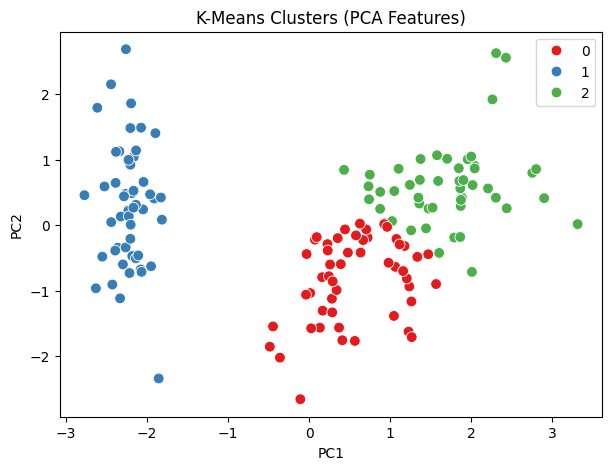



K-Means Confusion Matrix:
             Cluster 0  Cluster 1  Cluster 2
setosa              0         50          0
versicolor         39          0         11
virginica          14          0         36


K-Means Adjusted Rand Index: 0.6201351808870379


In [ ]:
# Choose k=3 (based on Elbow)
kmeans = KMeans(n_clusters=3, init='k-means++', random_state=42, n_init=10)
kmeans_labels = kmeans.fit_predict(X_pca)

# Visualize clusters using PCA
plt.figure(figsize=(7,5))
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=kmeans_labels, palette='Set1', s=60)
plt.title("K-Means Clusters (PCA Features)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

print('\n')

# Evaluation
cm_kmeans = confusion_matrix(y, kmeans_labels)
cm_kmeans_df = pd.DataFrame(cm_kmeans, index=target_names,
                            columns=[f'Cluster {i}' for i in range(cm_kmeans.shape[1])])
print("K-Means Confusion Matrix:\n", cm_kmeans_df)
print('\n')
print("K-Means Adjusted Rand Index:", adjusted_rand_score(y, kmeans_labels))


#B. Hierarchical Clustering

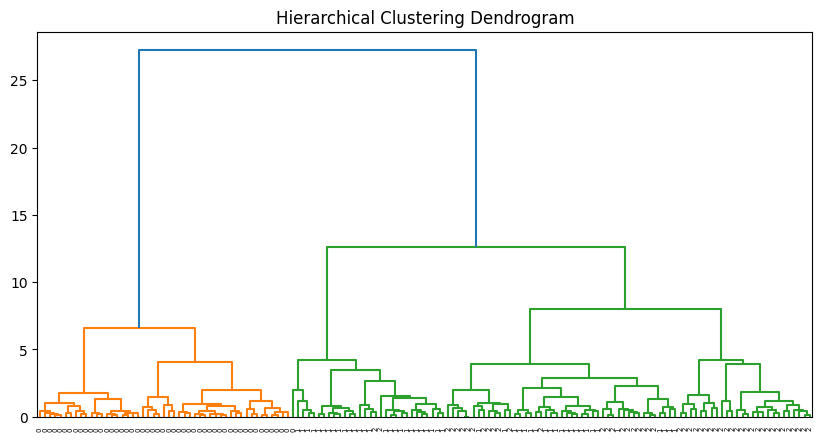

In [ ]:
# Dendrogram
linked = linkage(X_scaled, method='ward')
plt.figure(figsize=(10,5))
dendrogram(linked, labels=y, orientation='top', distance_sort='ascending')
plt.title('Hierarchical Clustering Dendrogram')
plt.show()

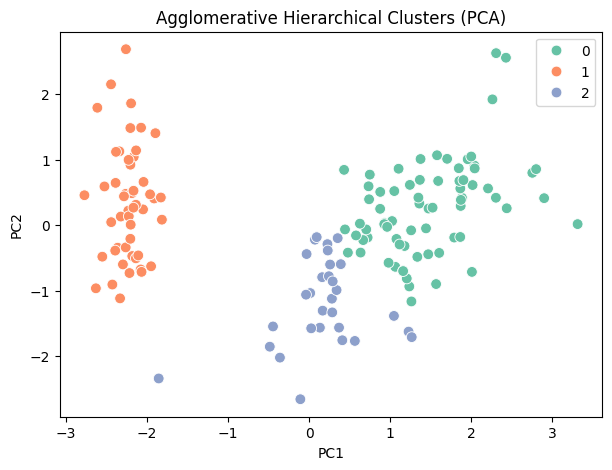



Agglomerative Hierarchical Confusion Matrix:
             Cluster 0  Cluster 1  Cluster 2
setosa              0         49          1
versicolor         23          0         27
virginica          48          0          2


Agglomerative Adjusted Rand Index: 0.6153229932145449


In [ ]:
# Agglomerative Clustering
agglo = AgglomerativeClustering(n_clusters=3, linkage='ward')
agglo_labels = agglo.fit_predict(X_scaled)

# Visualize clusters using PCA
plt.figure(figsize=(7,5))
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=agglo_labels, palette='Set2', s=60)
plt.title("Agglomerative Hierarchical Clusters (PCA)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

print('\n')

# Evaluation
cm_agglo = confusion_matrix(y, agglo_labels)
cm_agglo_df = pd.DataFrame(cm_agglo, index=target_names,
                           columns=[f'Cluster {i}' for i in range(cm_agglo.shape[1])])
print("Agglomerative Hierarchical Confusion Matrix:\n", cm_agglo_df)
print('\n')
print("Agglomerative Adjusted Rand Index:", adjusted_rand_score(y, agglo_labels))

##C. DBSCAN

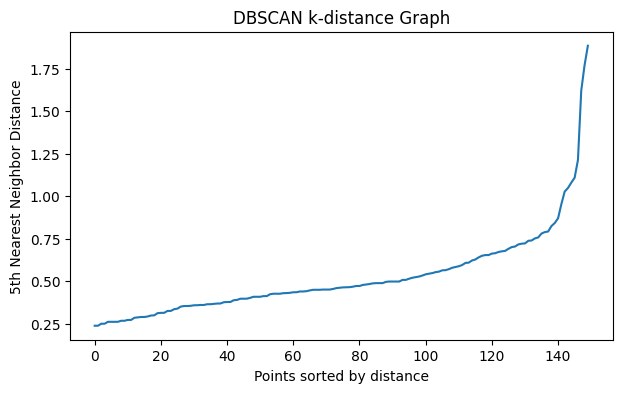

In [ ]:
# k-distance graph to choose eps
neighbors = NearestNeighbors(n_neighbors=5)
neighbors_fit = neighbors.fit(X_scaled)
distances, indices = neighbors_fit.kneighbors(X_scaled)
distances = np.sort(distances[:,4])

plt.figure(figsize=(7,4))
plt.plot(distances)
plt.title('DBSCAN k-distance Graph')
plt.xlabel('Points sorted by distance')
plt.ylabel('5th Nearest Neighbor Distance')
plt.show()

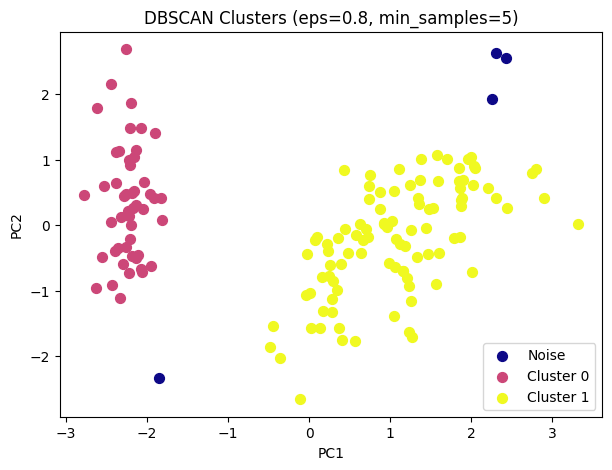



DBSCAN Confusion Matrix (Automatic Clusters + Noise):
            Noise  Cluster 0  Cluster 1
setosa          1         49          0
versicolor      0          0         50
virginica       3          0         47

DBSCAN Adjusted Rand Index: 0.5517553852833211


In [ ]:
# Run DBSCAN (eps based on graph)
eps_value = 0.8
min_samples = 5

# Run DBSCAN
dbscan = DBSCAN(eps=eps_value, min_samples=min_samples)
y_dbscan = dbscan.fit_predict(X_scaled)

# Visualize clusters in PCA 2D
unique_labels = np.unique(y_dbscan)
colors = plt.cm.plasma(np.linspace(0, 1, len(unique_labels)))

plt.figure(figsize=(7,5))
for label, color in zip(unique_labels, colors):
    mask = (y_dbscan == label)
    lbl = 'Noise' if label == -1 else f'Cluster {label}'
    plt.scatter(X_pca[mask,0], X_pca[mask,1], c=[color], label=lbl, s=50)

plt.title(f'DBSCAN Clusters (eps={eps_value}, min_samples={min_samples})')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend()
plt.show()

print('\n')

# Confusion Matrix (automatic clusters + noise)
cm_full = np.zeros((len(target_names), len(unique_labels)), dtype=int)
for i, cluster in enumerate(unique_labels):
    for j in range(len(target_names)):
        cm_full[j,i] = np.sum((y==j) & (y_dbscan==cluster))

cm_dbscan_df = pd.DataFrame(cm_full, index=target_names,
                            columns=[f'Cluster {label}' if label != -1 else 'Noise'
                                     for label in unique_labels])

print("DBSCAN Confusion Matrix (Automatic Clusters + Noise):")
print(cm_dbscan_df)

# Adjusted Rand Index
ari = adjusted_rand_score(y, y_dbscan)
print("\nDBSCAN Adjusted Rand Index:", ari)
